In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from pathlib import Path
import glob
import numpy
import tensorflow as tf
from tensorflow import keras

from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
import pandas as pd

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow_hub as hub

%matplotlib notebook

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification
!unzip eye-diseases-classification.zip


# **Create Train/Validation/Test Splits**
-  First, split into 80% training and 20% test.
-  Split the training set further into 80% training and 20% validation.

# **Custom Augmentation Techniques:**
1. **Random Perspective Transformation:** Simulates slight changes in viewpoint or perspective by randomly shifting the image in the X and Y directions, which helps the model generalize better to different camera angles.
2. **Random Color Jitter:** This augmentation modifies the brightness, contrast, saturation, and hue of the image. It helps the model become invariant to lighting changes, making it more robust in varying real-world lighting conditions.
3.**Random Gaussian Noise:** Adds noise to the image to simulate real-world imperfections like sensor noise. This helps the model handle noisy input data better.
4. **Random Cutout:** Randomly removes parts of the image to simulate occlusion. It forces the model to focus on other parts of the image instead of relying on specific features.
5. **Random Elastic Deformation:** This augmentation distorts the image elastically, which simulates real-world distortions caused by bending or stretching. It can make the model more robust to various transformations.

In [ ]:
!pip install tensorflow-addons --upgrade --no-deps

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras import layers
from scipy.ndimage import gaussian_filter, map_coordinates
from google.colab.patches import cv2_imshow


# Custom augmentation: Add Gaussian Noise
def add_gaussian_noise_tf(image, mean=0, std=0.05):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=std)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 0.5)
    return noisy_image

# Data augmentation using TensorFlow + Custom augmentations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.1, fill_mode='nearest'),
    tf.keras.layers.RandomBrightness(0.005),
    tf.keras.layers.RandomContrast(0.005)
])

# function for augmentation
def augment_image_tf(image):
    image = data_augmentation(image)
    image = add_gaussian_noise_tf(image)
    return image





In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Rescaling layer
rescale = layers.Rescaling(1./255)
full_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    label_mode='categorical',
    shuffle=True  # Shuffle to ensure randomness
)

train_size = int(0.8 * len(full_ds))  # 80% for training
test_size = len(full_ds) - train_size  # 20% for testing

train_ds = full_ds.take(train_size)  # First 80% for training
test_ds = full_ds.skip(train_size)   # Last 20% for testing

# Split the train dataset into train (85%) and validation (15%)
val_size = int(0.15 * len(train_ds))
train_ds = train_ds.take(len(train_ds) - val_size)  # 85% for training
val_ds = train_ds.skip(len(train_ds) - val_size)  # 15% for validation

# Apply rescaling and augmentations to the train dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
train_ds = train_ds.map(lambda x, y: (tf.map_fn(augment_image_tf, x), y))

# Apply rescaling to the validation and test datasets (no augmentation)
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

print("Class names:", full_ds.class_names)


Found 4217 files belonging to 4 classes.
Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Train dataset size: 90
Validation dataset size: 15
Test dataset size: 27


In [ ]:
import tensorflow as tf

class_names= ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

def count_labels(dataset):
    label_counts = [0] * len(class_names)
    for _, labels in dataset:
        for label in labels.numpy():
            label_index = label.argmax()
            label_counts[label_index] += 1
    return label_counts

# Count the labels in train dataset
train_label_counts = count_labels(train_ds)
print("Train dataset label counts:")
for i, count in enumerate(train_label_counts):
    print(f"{class_names[i]}: {count}")

# Count the labels in validation dataset
val_label_counts = count_labels(val_ds)
print("\nValidation dataset label counts:")
for i, count in enumerate(val_label_counts):
    print(f"{class_names[i]}: {count}")

# Count the labels in test dataset
test_label_counts = count_labels(test_ds)
print("\nTest dataset label counts:")
for i, count in enumerate(test_label_counts):
    print(f"{class_names[i]}: {count}")


Train dataset label counts:
cataract: 718
diabetic_retinopathy: 744
glaucoma: 682
normal: 736

Validation dataset label counts:
cataract: 114
diabetic_retinopathy: 141
glaucoma: 98
normal: 127

Test dataset label counts:
cataract: 199
diabetic_retinopathy: 226
glaucoma: 211
normal: 221


# **Visualize the augmented images**

<IPython.core.display.Javascript object>

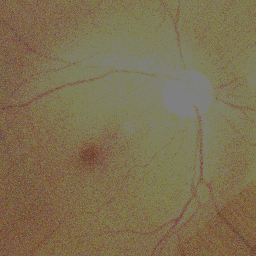

1


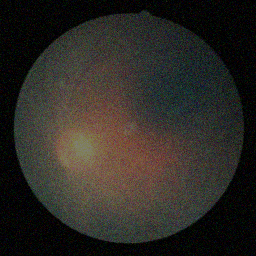

1


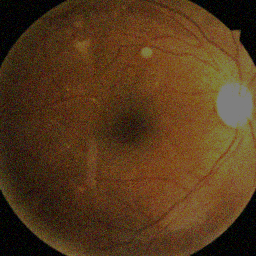

1


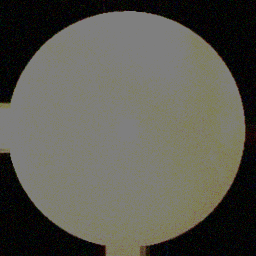

1


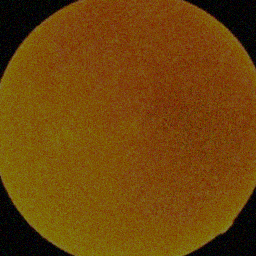

1


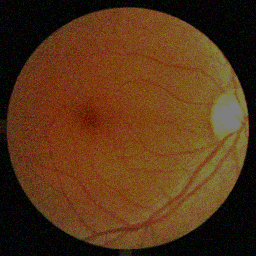

1


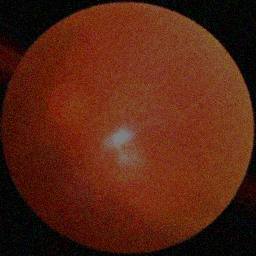

1


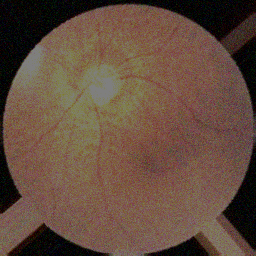

1


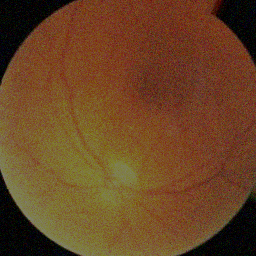

1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Displaying first 9 images
        ax = plt.subplot(3, 3, i + 1)
        image_data=(images[i].numpy())
        image_data_rescaled = (image_data * 255).astype('uint8')
        image_data_rescaled= cv2.cvtColor(image_data_rescaled, cv2.COLOR_BGR2RGB)#
        cv2_imshow(image_data_rescaled)
        label_index = np.argmax(labels[1].numpy())
        print(label_index)


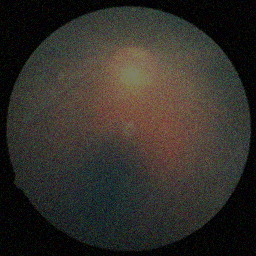

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

class_names=['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
for images, labels in train_ds.take(1):  # Take one batch
    image_data = images[1].numpy()
    label_index = np.argmax(labels[1].numpy())
    break

image_data_rescaled = (image_data * 255).astype('uint8')
image_data_rescaled= cv2.cvtColor(image_data_rescaled, cv2.COLOR_BGR2RGB)#
cv2_imshow(image_data_rescaled)
plt.title(f"Label: {class_names[label_index]}")
plt.axis('off')
plt.show()


# **Multi-class:**  
Each sample can belong to only one of several possible classes (e.g., an image can be classified as either 'cataract', 'diabetic_retinopathy', 'glaucoma', or 'normal', but not multiple of these at the same time).

**Probabilities:** The softmax output layer provides a probability for each class, and these probabilities will always sum to 1.

# **ResNet50**
- ResNet50 is a deep convolutional neural network model that was originally trained on the **ImageNet** dataset.
- **ImageNet** is a large-scale dataset consisting of millions of labeled images across 1,000 classes.
- These classes include a wide variety of objects such as animals, vehicles, plants, and common items, but **it does not include specific categories related to medical images like eye diseases**.
- It can still be very useful for other tasks, including image classification in domains like **medical image analysis**, with proper fine-tuning.

### How It Can Still Help with Eye Disease Classification:
While ResNet50 was not trained on eye disease images specifically, **transfer learning** makes it a powerful tool for tasks like eye disease classification.
1. **Learned Features**: ResNet50 has learned to recognize general patterns (e.g., edges, shapes, textures, and complex features) from the ImageNet dataset, which are often shared across different types of images, including medical images like eye images.
   
2. **Fine-Tuning**: By using the pre-trained ResNet50 model and fine-tuning it with your specific eye disease dataset (e.g., cataracts, diabetic retinopathy, glaucoma, etc.), the model can adapt its learned features to focus on more relevant patterns within your dataset. The early layers of ResNet50 will already be detecting basic features, and the later layers will be adjusted to focus on the specifics of the eye disease images.

3. **Better Generalization**: Transfer learning allows the model to generalize better to new tasks (like medical image classification) because it starts with a knowledge base that was built from a large and diverse dataset (ImageNet).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# 1. Load the pre-trained ResNet50 model
base_resnet = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze the ResNet50 layers
base_resnet.trainable = False

# 2. Define the custom CNN branch
input_layer = layers.Input(shape=(256, 256, 3))

# First branch - Custom CNN
custom_x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
custom_x = layers.MaxPooling2D((2, 2))(custom_x)
custom_x = layers.Conv2D(64, (3, 3), activation='relu')(custom_x)
custom_x = layers.MaxPooling2D((2, 2))(custom_x)
custom_x = layers.Conv2D(128, (3, 3), activation='relu')(custom_x)
custom_x = layers.MaxPooling2D((2, 2))(custom_x)
custom_x = layers.Conv2D(256, (3, 3), activation='relu')(custom_x)
custom_x = layers.MaxPooling2D((2, 2))(custom_x)
custom_x = layers.Flatten()(custom_x)
custom_x = layers.Dense(64, activation='relu')(custom_x)
custom_x = layers.Dropout(0.5)(custom_x)

# Second branch - ResNet50
resnet_x = base_resnet(input_layer)
resnet_x = layers.GlobalAveragePooling2D()(resnet_x)
resnet_x = layers.Dense(64, activation='relu')(resnet_x)

# Combine both branches
combined = layers.Concatenate()([custom_x, resnet_x])

# Common layers after combination
x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
output = layers.Dense(4, activation='softmax')(x)

# combined model
model = Model(inputs=input_layer, outputs=output)

combined_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=[early_stopping])


Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 638s 7s/step - accuracy: 0.3961 - loss: 1.3569 - val_accuracy: 0.5771 - val_loss: 0.8819
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 594s 7s/step - accuracy: 0.6267 - loss: 0.8044 - val_accuracy: 0.7042 - val_loss: 0.6623
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 625s 7s/step - accuracy: 0.7165 - loss: 0.6535 - val_accuracy: 0.7708 - val_loss: 0.5344
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 615s 7s/step - accuracy: 0.7677 - loss: 0.5504 - val_accuracy: 0.7917 - val_loss: 0.4829
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 598s 7s/step - accuracy: 0.8072 - loss: 0.4707 - val_accuracy: 0.8208 - val_loss: 0.4257
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.8218 - loss: 0.4287 - val_accuracy: 0.8375 - val_loss: 0.3400
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 586s 6s/step - accuracy: 0.8386 - loss: 0.3899 - val_accuracy: 0.8750 - val_loss: 0.2998
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.8356 - loss: 0.3870 - val_accuracy: 0.8750 - v

In [ ]:
#model.save('ml_eye_disease_model.keras')
model = tf.keras.models.load_model('ml_eye_disease_model.keras')

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8577 - loss: 0.4426
Test accuracy: 0.8530


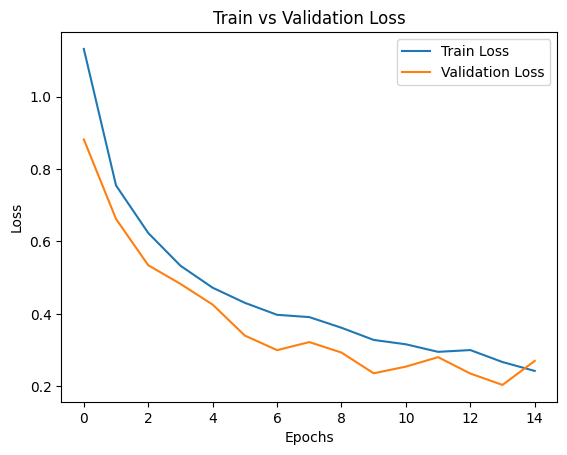

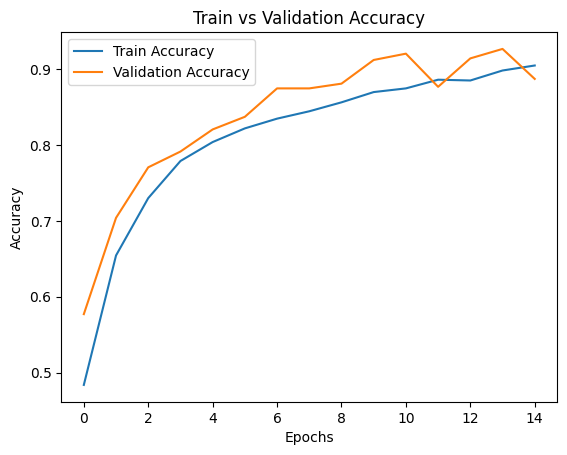

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

if 'loss' in history.history and 'accuracy' in history.history:
    # Plot training & validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training & validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Training history is not available or does not contain the expected keys.")



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = []
y_pred = []

# Iterate over the test dataset
for img_batch, label_batch in test_ds:
    y_true.extend(label_batch.numpy())

    # Perform predictions
    preds = model(img_batch, training=False)  # Use model for predictions
    y_pred.extend(tf.argmax(preds, axis=1).numpy())  # Get the predicted labels and store them

# # Convert the list to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred)



In [ ]:
accuracy = accuracy_score(y_true.argmax(axis=1), y_pred)
precision = precision_score(y_true.argmax(axis=1), y_pred, average='weighted')  # Weighted for multi-class
recall = recall_score(y_true.argmax(axis=1), y_pred, average='weighted')
f1 = f1_score(y_true.argmax(axis=1), y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.8471
Precision: 0.8574
Recall: 0.8471
F1-Score: 0.8444


In [ ]:
# Calculate and print metrics for each class
for class_index in range(len(class_names)):
    true_labels = (y_true.argmax(axis=1) == class_index).astype(int)
    predicted_labels = (y_pred == class_index).astype(int)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Print metrics for the current class
    print(f"\nMetrics for class {class_names[class_index]}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


Metrics for class cataract:
  Accuracy: 0.9113
  Precision: 0.8086
  Recall: 0.8244
  F1-Score: 0.8164

Metrics for class diabetic_retinopathy:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Metrics for class glaucoma:
  Accuracy: 0.8880
  Precision: 0.8824
  Recall: 0.6338
  F1-Score: 0.7377

Metrics for class normal:
  Accuracy: 0.8950
  Precision: 0.7306
  Recall: 0.9209
  F1-Score: 0.8148


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

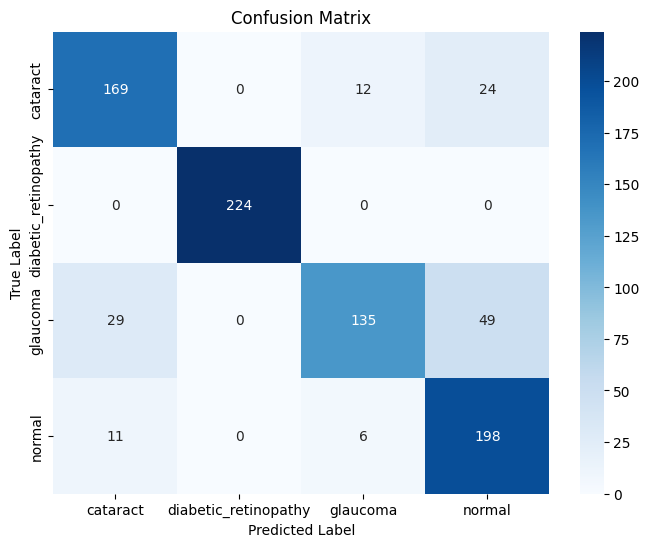

In [ ]:
%matplotlib inline

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<IPython.core.display.Javascript object>

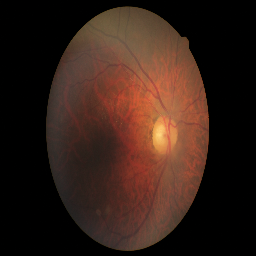

True: glaucoma
Pred: glaucoma


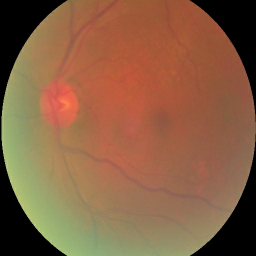

True: normal
Pred: normal


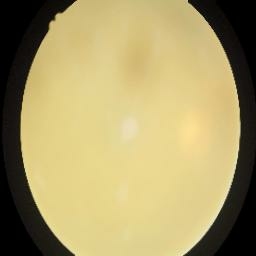

True: cataract
Pred: cataract


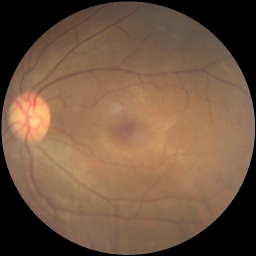

True: normal
Pred: normal


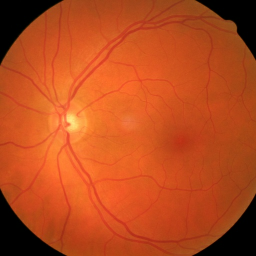

True: diabetic_retinopathy
Pred: diabetic_retinopathy


In [ ]:
# Display a few sample predictions with corresponding labels
num_samples = 5
plt.figure(figsize=(10, 10))

for i, (img_batch, label_batch) in enumerate(test_ds.take(1)):  # Get a batch of test data
    for j in range(num_samples):
        plt.subplot(1, num_samples, j + 1)

        # Image
        img = img_batch[j]  # Get the image
        true_label = label_batch[j]  # Get the true label

        # Prediction
        pred_label = model(tf.expand_dims(img, axis=0), training=False)
        pred_label = tf.argmax(pred_label, axis=1).numpy()[0]

        img_np = img.numpy()
        image_data_rescaled = (img_np * 255).astype('uint8')
        image_data_rescaled= cv2.cvtColor(image_data_rescaled, cv2.COLOR_BGR2RGB)
        cv2_imshow(image_data_rescaled)

        true_labels_text = [class_names[k] for k in range(len(true_label)) if true_label[k] == 1]
        pred_labels_text = [class_names[pred_label]]

        print(f"True: {', '.join(true_labels_text)}\nPred: {', '.join(pred_labels_text)}")

plt.show()
